In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import myUtils as ut
import numpy as np
import pandas as pd
import random

from lazypredict.supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

from PyBioMed.Pyprotein import CalculateAAComposition, CalculateDipeptideComposition, CalculateCTD, GetAPseudoAAC

In [2]:
ut.import_data()

In [3]:
sequences_ne = ut.parse_sequences("nonAMP_sequence\\nonAMP_sequence.fasta")
sequences_po = ut.parse_sequences("AMP_sequence\\AMP_sequence.fasta")

random.Random(42).shuffle(sequences_ne)
random.Random(42).shuffle(sequences_po)

print("Count positive AMP:", len(sequences_po))
print("Count negative AMP:", len(sequences_ne))

Count positive AMP: 3268
Count negative AMP: 166791


In [4]:
train_po = sequences_po[:-500]
train_ne = sequences_ne[:len(train_po)]

In [5]:
train_data = ut.prep_data(train_po,train_ne, [CalculateAAComposition, CalculateCTD], verbose=True)
#train_data = prep_data(train_po,train_ne, [CalculateAAComposition, CalculateCTD, pseudoAAC])

Extraced 168 features from 5536 sequences


In [6]:
train_X = train_data.drop('activity', axis=1)
train_Y = train_data['activity'].copy()

selected_features = ut.select_features(train_X)
train_X = ut.filter_features(train_X, selected_features)

In [7]:
training_features_mask = pd.DataFrame(selected_features, columns=['mask'])
training_features_mask.to_csv("Models\RF_input_features_mask.csv")

In [8]:
# Load dataset
X = train_X
Y = train_Y

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

# Defines and builds the lazyclassifier
clf = LazyClassifier(verbose=False, ignore_warnings=True, custom_metric=matthews_corrcoef)

In [9]:
models,predictions = clf.fit(X_train, X_test, Y_train, Y_test)

 97%|█████████▋| 28/29 [00:29<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 2214, number of negative: 2214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31575
[LightGBM] [Info] Number of data points in the train set: 4428, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


[(0.0, 1.0)]

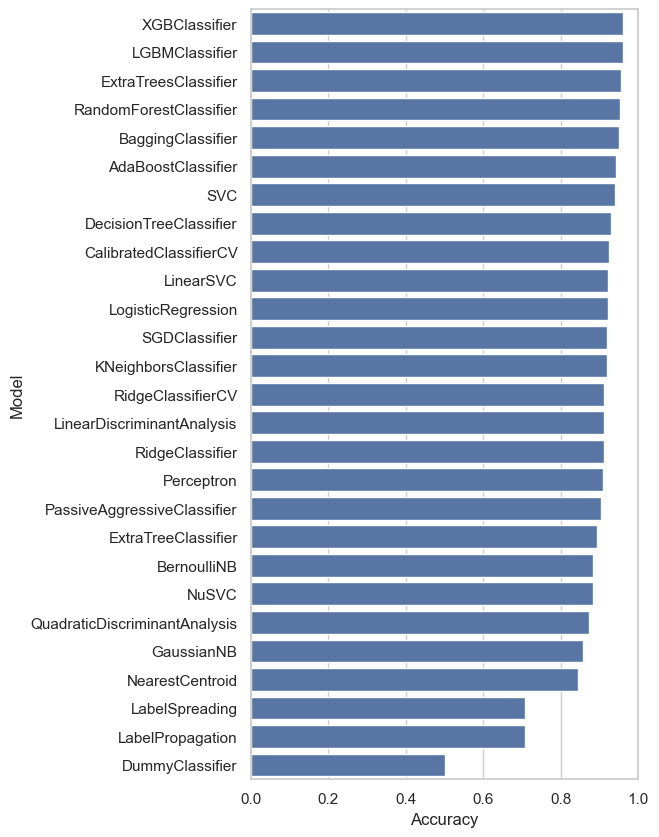

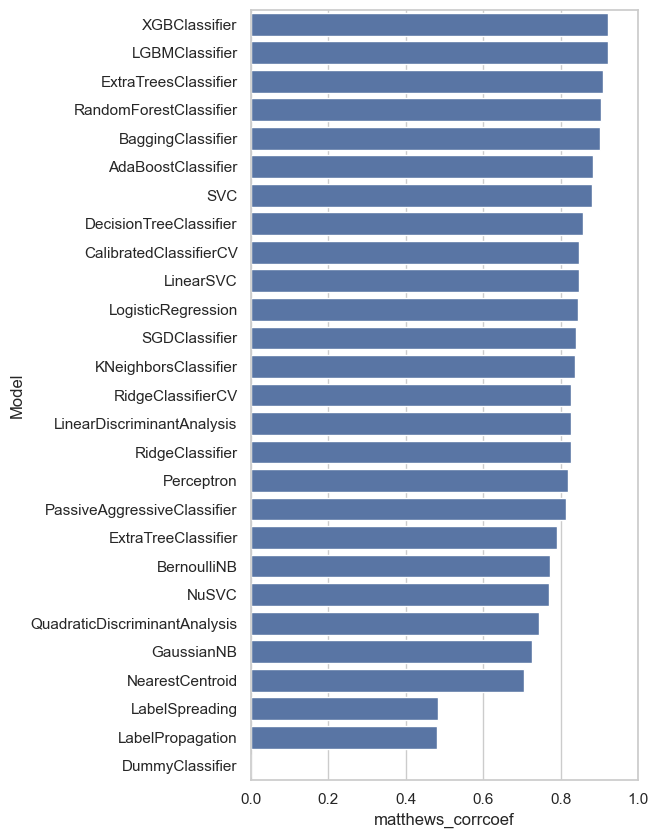

In [10]:
# Plot of Accuracy
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, x="Accuracy", data=models)
ax.set(xlim=(0, 1))
     

# Plot of MCC
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models.index, x="matthews_corrcoef", data=models)
ax.set(xlim=(0, 1))

In [73]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=250, criterion="gini", oob_score=True)
gb = GradientBoostingClassifier(n_estimators=250)

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

rf.fit(X_train, Y_train)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=250)

In [74]:
print('Random Forrest score:', rf.score(X_test, Y_test))
print('Gradient Boost score:', gb.score(X_test, Y_test))

Random Forrest score: 0.9512635379061372
Gradient Boost score: 0.9512635379061372


In [75]:
from sklearn.metrics import matthews_corrcoef

print( 'Random Forrest MCC:', matthews_corrcoef(Y_test, rf.predict(X_test)))
print('Gradient Boost MCC:', matthews_corrcoef(Y_test, gb.predict(X_test)))

Random Forrest MCC: 0.9029037123673941
Gradient Boost MCC: 0.9025800118490127


In [76]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(mat):
    print('TP:', mat[0,0])
    print('FP:', mat[0,1])
    print('FN:', mat[1,0])
    print('TN:', mat[1,1])

confusion_mat = confusion_matrix(Y_test, rf.predict(X_test))
print_confusion_matrix(confusion_mat)
print('--------')
confusion_mat = confusion_matrix(Y_test, gb.predict(X_test))
print_confusion_matrix(confusion_mat)

TP: 519
FP: 35
FN: 19
TN: 535
--------
TP: 524
FP: 30
FN: 24
TN: 530


In [77]:
from sklearn.metrics import classification_report

y_train_pred = rf.predict(X_train)
model_report = classification_report(Y_train, y_train_pred, target_names=['positive','negative'])

f = open('random_forrest_model_report.txt','w')
f.writelines(model_report) 
f.close()

y_train_pred = gb.predict(X_train)
model_report = classification_report(Y_train, y_train_pred, target_names=['positive','negative'])

f = open('gradient_boost_model_report.txt','w')
f.writelines(model_report) 
f.close()

Text(0.5, 0, 'Feature Importance')

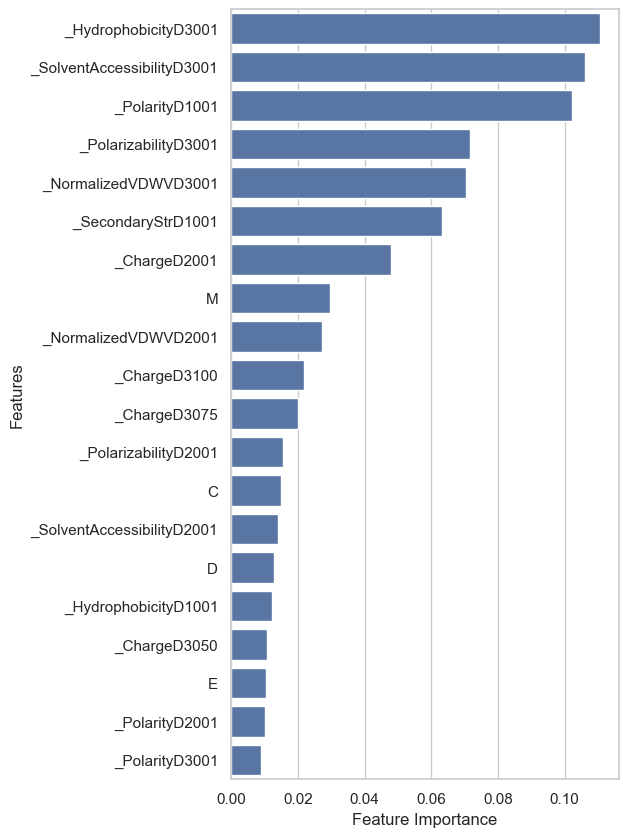

In [78]:
importance = pd.Series(rf.feature_importances_, name = 'Gini')
feature_names = pd.Series(X.columns, name='Features')

df = pd.concat([feature_names, importance], axis=1, names=['Features', 'Gini'])

import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False)[:20] # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Features', data = df_sorted)
plt.xlabel("Feature Importance")

Text(0.5, 0, 'Feature Importance')

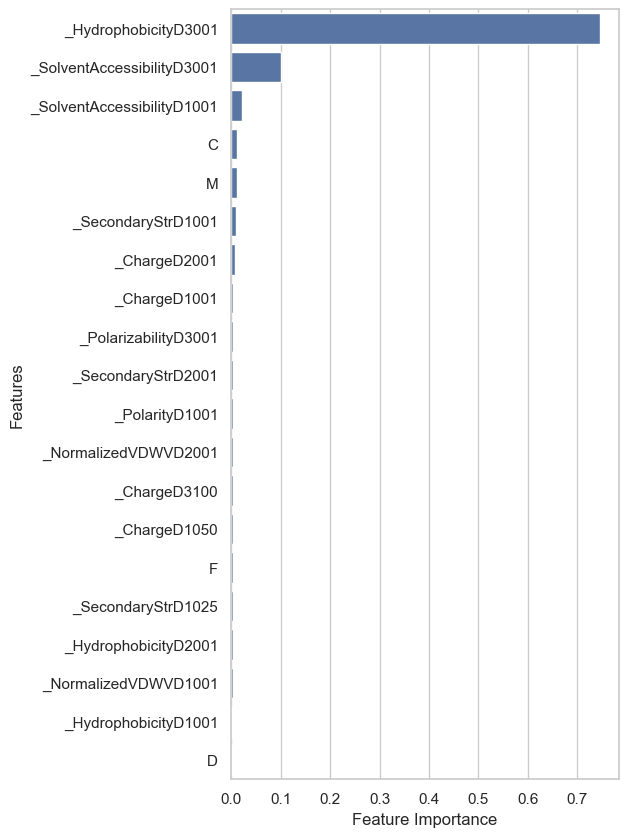

In [79]:
importance = pd.Series(gb.feature_importances_, name = 'Gini')
feature_names = pd.Series(X.columns, name='Features')

df = pd.concat([feature_names, importance], axis=1, names=['Features', 'Gini'])

import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values('Gini', ascending=False)[:20] # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'Gini', y = 'Features', data = df_sorted)
plt.xlabel("Feature Importance")

In [59]:
test_po = sequences_po[-500:]
test_ne = sequences_ne[-1000:]

In [60]:
test_data = ut.prep_data(test_po,test_ne, [CalculateAAComposition, CalculateCTD])
#test_data = prep_data(test_po,test_ne, [CalculateAAComposition, CalculateCTD, pseudoAAC])

In [61]:
test_X = test_data.drop('activity', axis=1)
test_Y = test_data['activity'].copy()

test_X = ut.filter_features(test_X, selected_features)

In [62]:
rf_score = rf.score(test_X, test_Y)
gb_score = gb.score(test_X, test_Y)

print('Random Forrest Accuracy:', rf_score)
print('Gradient Boost Accuracy:', gb_score)

Random Forrest Accuracy: 0.95
Gradient Boost Accuracy: 0.956


In [63]:
confusion_mat = confusion_matrix(rf.predict(test_X), test_Y)
print_confusion_matrix(confusion_mat)

TP: 936
FP: 11
FN: 64
TN: 489


In [64]:
confusion_mat = confusion_matrix(gb.predict(test_X), test_Y)
print_confusion_matrix(confusion_mat)

TP: 949
FP: 15
FN: 51
TN: 485


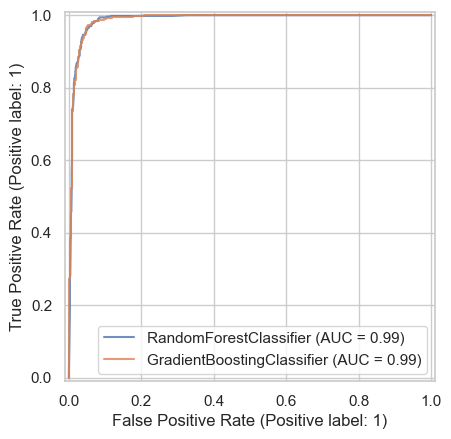

In [65]:
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()
rf_disp = RocCurveDisplay.from_estimator(rf, test_X, test_Y, ax=ax, alpha=0.8)
gb_disp = RocCurveDisplay.from_estimator(gb, test_X, test_Y, ax=ax, alpha=0.8)
plt.show()

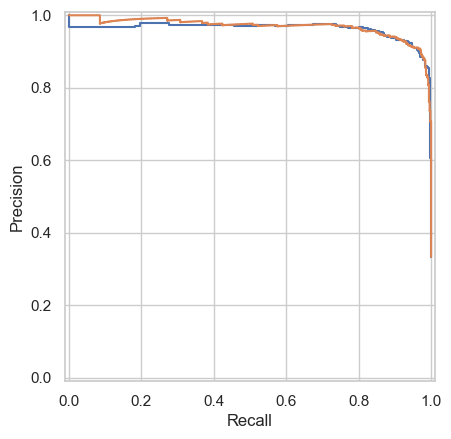

In [66]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc

ax = plt.gca()
rf_predictions = rf.predict_proba(test_X)[:,1]
rf_prec, rf_recall, _ = precision_recall_curve(test_Y, rf_predictions, pos_label=rf.classes_[1])
rf_pred_recall = PrecisionRecallDisplay(precision=rf_prec, recall=rf_recall).plot(ax=ax)

gb_predictions = gb.predict_proba(test_X)[:,1]
gb_prec, gb_recall, _ = precision_recall_curve(test_Y, gb_predictions, pos_label=gb.classes_[1])
gb_pred_recall = PrecisionRecallDisplay(precision=gb_prec, recall=gb_recall).plot(ax=ax)

In [67]:
rf_auc = auc(rf_recall, rf_prec)
gb_auc = auc(gb_recall, gb_prec)

print('Random Forest AUC:', rf_auc)
print('Gradient Boost AUC:', gb_auc)

Random Forest AUC: 0.965387294084047
Gradient Boost AUC: 0.9694421440083669


In [68]:
from joblib import dump, load

#dump(rf, 'Models\RF_classifier.joblib') 
#dump(gb, 'Models\GB_classifier.joblib') 